# Plant Classification

# Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms # for processing datasets
from torch.utils.data import DataLoader # for making dataset easier to use 

from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


# Hyper parameter setting

In [2]:
# hypter parameter setting
learning_rate = 1e-3 # 어려운 데이터는 learning rate 10의-3승~4승정도로 해줘야 함
training_epochs = 300
display_step = 10
batch_size = 32
activation = nn.ReLU()
max_pool = nn.MaxPool2d(2,2) # kernel size, stride size, padding size 
dropout_rate = 0.5

# Load data & Pre-process data

In [3]:
trans = transforms.Compose([transforms.Resize(32), transforms.ToTensor()]) 
dataset = torchvision.datasets.ImageFolder(root = 'C:/Users/pirl/Desktop/aicontest/NIPA_하반기 경진대회_사전검증/train', transform = trans) 

In [4]:
dataset.__getitem__(0)

(tensor([[[0.0000, 0.0000, 0.0039,  ..., 0.5255, 0.5569, 0.2627],
          [0.0000, 0.0000, 0.0000,  ..., 0.5294, 0.4627, 0.0902],
          [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.2314, 0.0118],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0039,  ..., 0.5804, 0.5569, 0.2549],
          [0.0000, 0.0000, 0.0000,  ..., 0.5922, 0.4588, 0.0824],
          [0.0000, 0.0000, 0.0000,  ..., 0.5412, 0.2157, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0039, 0.0078,  ..., 0.4784, 0.4549, 0.2196],
          [0.0000, 0.0000, 0.0039,  ..., 0.4824, 0.3882, 0.0784],
          [0.0000, 0.0000, 0.0000,  ...,

In [5]:
len(dataset)

16000

In [6]:
classes = dataset.classes
classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [7]:
len(dataset)*(6/8), len(dataset)*(2/8) # train:validation:test = 6:2:2

(12000.0, 4000.0)

len(train_data):  12000
len(val_data):  4000
data tensor([[[0.5529, 0.4627, 0.4314],
         [0.5608, 0.4667, 0.4353],
         [0.5804, 0.4745, 0.4471],
         ...,
         [0.5961, 0.5176, 0.4824],
         [0.6039, 0.5255, 0.4902],
         [0.6000, 0.5216, 0.4863]],

        [[0.5529, 0.4627, 0.4314],
         [0.5647, 0.4706, 0.4392],
         [0.5725, 0.4706, 0.4392],
         ...,
         [0.6039, 0.5255, 0.4902],
         [0.6078, 0.5294, 0.4980],
         [0.6235, 0.5451, 0.5098]],

        [[0.4706, 0.3804, 0.3490],
         [0.4667, 0.3765, 0.3490],
         [0.5059, 0.4039, 0.3765],
         ...,
         [0.6196, 0.5412, 0.5059],
         [0.5843, 0.5059, 0.4745],
         [0.6157, 0.5373, 0.5098]],

        ...,

        [[0.3961, 0.3059, 0.2902],
         [0.4196, 0.3255, 0.3098],
         [0.4510, 0.3569, 0.3373],
         ...,
         [0.6392, 0.5647, 0.5412],
         [0.6431, 0.5686, 0.5412],
         [0.6627, 0.5882, 0.5608]],

        [[0.4902, 0.4000, 0.3765

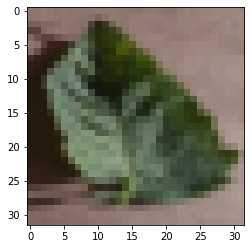

In [8]:
train_data, val_data = torch.utils.data.random_split(dataset, [int(len(dataset)*(6/8)), int(len(dataset)*(2/8))])

# check the data
print('len(train_data): ', len(train_data))
print('len(val_data): ', len(val_data))

x_train, y_train = train_data[0]
x_train = np.transpose(x_train, (1, 2, 0))

# 32 x 32 x 3

print('data', x_train)
print('data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train)
plt.show()

data shape: torch.Size([32, 3, 32, 32])
label: tensor([ 5,  3,  3, 11, 19, 18, 10, 18,  5, 12, 18,  6, 15, 19,  3, 16, 16, 17,
         1, 15, 12, 11, 17, 10, 19, 15,  5, 13, 18, 17, 17, 15])


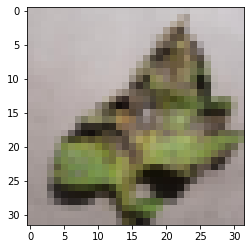

In [9]:
# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('data shape:', example_data.shape)
print('label:', example_target)

check_image = example_data[0]
check_image = np.transpose(check_image, (1, 2, 0))

plt.figure()
plt.imshow(check_image)
plt.show()

# Model & Optimization and Loss function

### VGG 19

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # for initializing nn.Module (parent class)
        self.feature_extraction = nn.Sequential(
            
            # 3 x 32 x 32
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_rate),
            activation,
            nn.Conv2d(64, 64, 3, padding=1), 
            nn.BatchNorm2d(64),
            activation,        
            max_pool,
            
            # 64 x 16 x 16
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_rate),
            activation,
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            activation,
            max_pool,
            
            # 128 x 8 x 8
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.Dropout(dropout_rate),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.Dropout(dropout_rate),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            activation,
            max_pool,
            
            # 256 x 4 x 4
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(dropout_rate),
            activation,
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(dropout_rate),
            activation,
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            activation,
            max_pool,
            
            # 512 x 2 x 2
            
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(dropout_rate),
            activation,
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(dropout_rate),
            activation,
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(dropout_rate),
            activation,
            max_pool,
            
            # 512 x 1 x 1
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 100),
            nn.Dropout(dropout_rate),
            activation,
            nn.Linear(100, 50),
            activation,
            nn.Linear(50, 20),
        )
    def forward(self, x):
        extracted_feature = self.feature_extraction(x)
        flatten = extracted_feature.view(batch_size, -1)
        result = self.classifier(flatten)
        return result

model = CNN().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train & Test

In [11]:
loss_array = []

# train the model
for i in range(training_epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())

0 epoch loss: 2.6694226264953613
10 epoch loss: 0.942948043346405
20 epoch loss: 0.618545413017273
30 epoch loss: 0.4742112457752228
40 epoch loss: 0.2570444345474243
50 epoch loss: 0.3805188834667206
60 epoch loss: 0.2703671455383301
70 epoch loss: 0.08094873279333115
80 epoch loss: 0.12312931567430496
90 epoch loss: 0.14385029673576355
100 epoch loss: 0.38299888372421265
110 epoch loss: 0.03175614774227142
120 epoch loss: 0.019573060795664787
130 epoch loss: 0.004878736101090908
140 epoch loss: 0.03361360728740692
150 epoch loss: 0.5525057315826416
160 epoch loss: 0.0424310676753521
170 epoch loss: 0.044199388474226
180 epoch loss: 0.06679234653711319
190 epoch loss: 0.027385223656892776
200 epoch loss: 0.014201797544956207
210 epoch loss: 0.012613984756171703
220 epoch loss: 0.0017224433831870556
230 epoch loss: 0.021829182282090187
240 epoch loss: 0.004601249936968088
250 epoch loss: 0.0005581672885455191
260 epoch loss: 0.015114924870431423
270 epoch loss: 0.002290068892762065
280

In [ ]:
# model_dir = './trained_model'

# def save_model(model, model_dir):
#     print("Saving the model.")
#     path = os.path.join(model_dir, 'model.pth')
#     torch.save(model.cpu().state_dict(), path)

# save_model(model, model_dir)

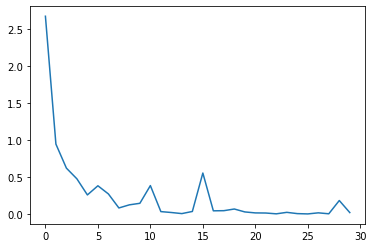

In [13]:
plt.figure()
plt.plot(loss_array)
plt.show()

### Accuracy

In [14]:
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(val_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()
        
        val_accuracy = correct/total

print("Validation accuraccy: {}".format(val_accuracy))

Validation accuraccy: 0.9530000686645508


In [15]:
len(prediction_list), len(label_list)

(125, 125)

In [16]:
y_pred = []
for prediction in prediction_list:
    prediction = prediction.tolist()
    y_pred += prediction
y_pred

[2,
 14,
 12,
 1,
 6,
 4,
 16,
 4,
 10,
 18,
 6,
 7,
 17,
 19,
 15,
 0,
 18,
 8,
 8,
 12,
 4,
 10,
 16,
 1,
 6,
 0,
 11,
 10,
 4,
 14,
 8,
 9,
 2,
 6,
 4,
 0,
 1,
 16,
 0,
 19,
 0,
 11,
 17,
 3,
 15,
 19,
 14,
 5,
 6,
 10,
 7,
 7,
 6,
 0,
 13,
 17,
 3,
 12,
 16,
 7,
 3,
 14,
 10,
 6,
 8,
 10,
 4,
 6,
 17,
 6,
 9,
 11,
 7,
 19,
 2,
 11,
 15,
 19,
 10,
 11,
 13,
 2,
 10,
 9,
 14,
 11,
 13,
 11,
 17,
 15,
 18,
 4,
 17,
 11,
 15,
 18,
 9,
 13,
 19,
 12,
 18,
 4,
 4,
 11,
 19,
 9,
 9,
 8,
 7,
 1,
 2,
 15,
 15,
 16,
 15,
 14,
 18,
 15,
 14,
 2,
 1,
 4,
 1,
 19,
 3,
 0,
 16,
 11,
 7,
 17,
 11,
 19,
 16,
 5,
 11,
 1,
 12,
 13,
 13,
 11,
 12,
 17,
 3,
 19,
 15,
 10,
 5,
 11,
 18,
 5,
 19,
 0,
 8,
 0,
 7,
 7,
 6,
 19,
 12,
 10,
 10,
 15,
 2,
 3,
 11,
 13,
 5,
 2,
 11,
 18,
 13,
 8,
 9,
 6,
 2,
 6,
 9,
 17,
 5,
 16,
 0,
 12,
 1,
 0,
 11,
 10,
 3,
 6,
 15,
 7,
 14,
 0,
 0,
 10,
 9,
 17,
 8,
 8,
 7,
 1,
 6,
 12,
 1,
 13,
 6,
 12,
 0,
 14,
 8,
 6,
 3,
 7,
 1,
 4,
 10,
 15,
 0,
 6,
 18,
 19,
 5,
 1,


In [17]:
y_true = []
for label in label_list:
    label = label.tolist()
    y_true += label
y_true

[2,
 14,
 12,
 1,
 6,
 4,
 16,
 5,
 10,
 18,
 6,
 7,
 16,
 19,
 15,
 0,
 18,
 8,
 8,
 12,
 4,
 10,
 16,
 1,
 6,
 0,
 11,
 10,
 4,
 14,
 8,
 9,
 2,
 6,
 4,
 0,
 1,
 16,
 0,
 19,
 0,
 9,
 17,
 3,
 16,
 19,
 14,
 5,
 6,
 10,
 7,
 7,
 6,
 0,
 13,
 17,
 3,
 12,
 16,
 7,
 3,
 14,
 10,
 6,
 8,
 10,
 4,
 5,
 17,
 6,
 9,
 11,
 7,
 19,
 2,
 11,
 15,
 19,
 10,
 11,
 13,
 2,
 10,
 19,
 14,
 11,
 13,
 11,
 17,
 15,
 18,
 4,
 17,
 11,
 15,
 18,
 9,
 13,
 19,
 12,
 18,
 4,
 5,
 11,
 19,
 9,
 9,
 8,
 7,
 1,
 2,
 15,
 15,
 16,
 15,
 14,
 18,
 15,
 14,
 2,
 1,
 5,
 1,
 19,
 3,
 0,
 16,
 11,
 7,
 17,
 11,
 19,
 16,
 5,
 11,
 1,
 12,
 13,
 13,
 11,
 12,
 17,
 3,
 19,
 15,
 10,
 5,
 11,
 18,
 5,
 19,
 0,
 8,
 0,
 7,
 7,
 6,
 19,
 12,
 10,
 10,
 16,
 2,
 3,
 11,
 13,
 5,
 2,
 11,
 18,
 13,
 8,
 8,
 6,
 2,
 6,
 9,
 17,
 5,
 16,
 6,
 12,
 1,
 0,
 11,
 10,
 3,
 6,
 15,
 7,
 14,
 0,
 0,
 10,
 9,
 17,
 8,
 8,
 7,
 1,
 6,
 12,
 1,
 13,
 6,
 12,
 0,
 14,
 8,
 6,
 3,
 7,
 1,
 4,
 10,
 15,
 0,
 5,
 18,
 19,
 5,
 1,


### F1 score

In [18]:
# 'macro' : multiclass + 데이터 불균형 고려 X
metrics.f1_score(y_true, y_pred, average='macro')

0.9530529420831085

In [19]:
savePath = "./trained_model/test_model.pth"
torch.save(model.state_dict(), savePath)

In [20]:
#load

new_model = CNN().to(device)
new_model.load_state_dict(torch.load("./trained_model/test_model.pth"))

<All keys matched successfully>